In [48]:
from pandas_datareader import data 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import seaborn as sns
# from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit


from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

In [49]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

In [50]:
start_date = '2006-01-01'
end_data = '2019-12-31'
ticker = 'AAPL'

In [51]:
ticker_df = data.DataReader(ticker, 'yahoo', start_date, end_data)

In [52]:
ticker_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,2.669643,2.580357,2.585000,2.669643,807234400.0,2.302969
2006-01-04,2.713571,2.660714,2.683214,2.677500,619603600.0,2.309746
2006-01-05,2.675000,2.633929,2.672500,2.656429,449422400.0,2.291570
2006-01-06,2.739286,2.662500,2.687500,2.725000,704457600.0,2.350723
2006-01-09,2.757143,2.705000,2.740357,2.716071,675040800.0,2.343020


In [53]:
ticker_df["Close"].describe()

count    3523.000000
mean       20.946934
std        15.865012
min         1.809643
25%         6.524464
50%        18.536072
75%        29.795000
max        73.412498
Name: Close, dtype: float64

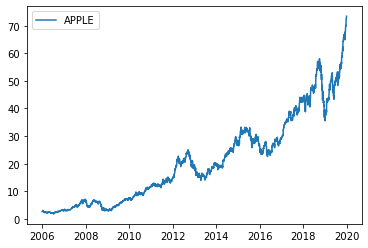

In [54]:
fig, ax = plt.subplots()
ax.plot(ticker_df.index, ticker_df["Close"], label = "APPLE")
ax.legend()

In [55]:
def momentum(df_):
    df = df_.copy()
    df["Momentum_1D"] = df["Close"].diff(1)
    df["Momentum_3D"] = df["Close"].diff(3)
    df["Momentum_5D"] = df["Close"].diff(5)
    df["Momentum_10D"] = df["Close"].diff(10)
    
    return df

In [56]:
def bollinger_bands(df_, window = 20, k = 2):
    df = df_.copy()
    days_ma_20 = df["Close"].rolling(window).mean()
    days_mstd_20 = df["Close"].rolling(window).std()
    upper_bound = days_ma_20 + k*days_mstd_20
    lower_bound = days_ma_20 - k*days_mstd_20
#     df["diff_between_upper_bollinger"] = df["Close"] - upper_bound
    diff_upp = df["Close"] - upper_bound
#     diff_upp[diff_upp > 0] = 1
#     diff_upp[diff_upp <= 0] = 0
    df["diff_between_upper_bollinger"] = diff_upp
    
#     df["diff_between_lower_bollinger"] = lower_bound - df["Close"]
    diff_low = lower_bound - df["Close"]
#     diff_low[diff_low > 0] = 1
#     diff_low[diff_low <= 0] = 0
    df["diff_between_lower_bollinger"] = diff_low
    return df


In [57]:
def aroon_osc(df_):
    df = df_.reset_index()
    df["up"] = np.nan
    df["down"] = np.nan
    for i in range(24, len(df)):
        temp = df[i-24: i+1].copy()
        max_ = temp["High"].max()
        index_max = temp[temp["High"] == max_].index[0]
        df.loc[i, "up"] = 100*((25 - (i - index_max))/25)


        min_ = temp["Low"].min()
        index_min = temp[temp["Low"] == min_].index[0]
        df.loc[i, "down"] = 100*((25 - (i - index_min))/25)

    df["aroon"] = df["up"] - df["down"]
    df = df.drop(columns = ["up", "down"])
    df = df.set_index("Date")
    
    return df

In [58]:
def CMFlow(df_):
    df = df_.copy()
    mfm = ((df["Close"] - df["Low"]) - (df["High"] - df["Close"])) / (df["High"] - df["Low"])
    mfv = mfm * df["Volume"]
    
    df["20_period_CMF"] = mfv.rolling(20).sum() / df["Volume"].rolling(20).sum()
    return df
    

In [72]:
def ichimoku_kinko_hyo(df_):
    df = df_.copy()
#     base line
    df["Kijun-Sen"] = (df["High"].rolling(26).max() + df["Low"].rolling(26).min()) / 2
#     conversion line
    df["Tenkan-Sen"] = (df["High"].rolling(9).max() + df["Low"].rolling(9).min()) / 2
    
    df["Chikou-Span"] = df["Close"].shift(-26)
#    leading span A
    df["Senkou-Span1"] = ((df["Tenkan-Sen"] + df["Kijun-Sen"])/2).shift(26)
#     leading span B
    df["Senkou-Span2"] = ((df["High"].rolling(52).max() + df["Low"].rolling(52).min()) / 2).shift(26)
    
#     first condition for buy signal
    b_1_1 = df["Close"] - df["Tenkan-Sen"]
    b_1_1[b_1_1 > 0] = 1
    b_1_1[b_1_1 < 0] = 0
    
    b_1_2 = df["Tenkan-Sen"] - df["Kijun-Sen"]
    b_1_2[b_1_2 > 0] = 1
    b_1_2[b_1_2 < 0] = 0
    
    b_1 = b_1_1 * b_1_2
    
#     second condition for buy signal
    b_2_1 = df["Close"] - df["Senkou-Span1"]
    b_2_1[b_2_1 > 0] = 1
    b_2_1[b_2_1 < 0] = 0
    
    b_2_2 = df["Senkou-Span1"] - df["Senkou-Span2"]
    b_2_2[b_2_2 > 0] = 1
    b_2_2[b_2_2 < 0] = 0
    
    b_2 = b_2_1 * b_2_2
    
#     third condition for buy signal
    b_3 = df["Chikou-Span"] - df["Close"].shift(25)
    b_3[b_3 > 0] = 1
    b_3[b_3 < 0] = 0
    
    df["IKH_BUY"] = b_1 * b_2* b_3
    
#     first condition for sell signal
    s_1_1 = df["Kijun-Sen"] - df["Tenkan-Sen"]
    s_1_1[s_1_1 > 0] = 1
    s_1_1[s_1_1 < 0] = 0
    
    s_1_2 = df["Tenkan-Sen"] - df["Close"]
    s_1_2[s_1_2 > 0] = 1
    s_1_2[s_1_2 < 0] = 0
    
    s_1 = s_1_1 * s_1_2
    
#     second condition for sell signal
    s_2_1 = df["Senkou-Span2"] - df["Senkou-Span1"]
    s_2_1[s_2_1 > 0] = 1
    s_2_1[s_2_1 < 0] = 0
    
    s_2_2 = df["Senkou-Span2"] - df["Close"]
    s_2_2[s_2_2 > 0] = 1
    s_2_2[s_2_2 < 0] = 0
    
    s_2 = s_2_1 * s_2_2 
    
    s_3 = df["Close"].shift(25) - df["Chikou-Span"]
    s_3[s_3 > 0] = 1
    s_3[s_3 < 0] = 0
    
    df["IKH_BUY"] = b_1 * b_2* b_3
    df["IKH_SELL"] = s_1 * s_2 * s_3
    

    df.drop(columns = ["Kijun-Sen", "Tenkan-Sen","Senkou-Span1", "Senkou-Span2", "Chikou-Span"], inplace = True)
    return df

In [60]:
def CCI(df_):
    df = df_.copy()
    positives = df["Close"].diff()[1:]
    positives[positives < 0] = 0
    
    
    tp = (df["High"] + df["Low"] + df["Close"]) / 3
    cci = (tp - tp.rolling(20).mean()) / (0.015 * tp.rolling(20).std())
    
    cci[(cci < 100) & (cci > -100)] = -1
    cci[cci <= -100] = 1
    cci[cci >= 100] = 0
    


    df["CCI_BUY_SELL"] = cci
    return df
    

In [61]:
def RSI(df_):
    df = df_.copy()
    positives = df["Close"].diff()[1:]
    negatives = df["Close"].diff()[1:]
    positives[positives < 0] = 0
    negatives[negatives > 0] = 0

    roll_up = positives.rolling(14).mean()
    roll_down = negatives.abs().rolling(14).mean()

    RS = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + RS))


    df["RSI_BUY_SELL"] = rsi
    
    return df

In [62]:
def MACD(df_):
    df = df_.copy()
    ewm12 = df["Close"].ewm(span = 12).mean()
    ewm26 = df["Close"].ewm(span = 26).mean()
    macd = ewm12 - ewm26



    signal = macd.ewm(span = 9).mean()
    
    hist = macd - signal

    
    df["MACD_Line"] = macd
    df["MACD_Hist"] = hist
    return df


In [63]:

# https://github.com/k3-coder/technical_indicators_lib/blob/master/technical_indicators_lib/indicators.py
def psar(barsdata_, iaf = 0.02, maxaf = 0.2):
    barsdata = barsdata_.copy()
    length = len(barsdata)
    high = list(barsdata['High'])
    low = list(barsdata['Low'])
    close = list(barsdata['Close'])
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = low[0]
    hp = high[0]
    lp = low[0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = high[i]
                af = iaf
        if not reverse:
            if bull:
                if high[i] > hp:
                    hp = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < lp:
                    lp = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]

    psar = barsdata["Close"] - psar

    barsdata["psar"] = psar
    return barsdata

In [64]:
def stochastic(df_):
    df = df_.copy()
    maxs = df["High"].rolling(14).max()
    mins = df["Low"].rolling(14).min()
    stochastic_k = (df["Close"] - mins)/(maxs - mins)*100
    stochastic_d = stochastic_k.rolling(3).mean()
    

    
    df["STCK_BUY_SELL"] = stochastic_k
    df["STCD_BUY_SELL"] = stochastic_k - stochastic_d
    
    
    return df

In [65]:
# def SMA_EMA(df_):
#     df = df_.copy()
#     sma = df["Close"].rolling(10).mean()    
#     sma_ = df["Close"] - sma
    
# #     sma_[sma_ > 0] = 1
# #     sma_[sma_ < 0] = 0
    
    
#     df["SMA_BUY"] = sma_
    
#     return df

In [66]:
def williams(df_):
    df = df_.copy()
    
#     positives = df["Close"].diff()[1:]
#     positives[positives < 0] = 0
    
    hh = df["High"].rolling(14).max()
    ll = df["Low"].rolling(14).min()
    
    R = ((hh - df["Close"]) / (hh - ll))*-100
    
#     R[R >= -20] = 1
#     R[R <= -80] = 0
#     R[(R != 1) & (R != 0) & (R.notnull())] = -1
    
#     positives[positives > 0] = 1 
    
#     R[R == -1] = positives[R[R == -1].index ]

    df["WilliamsR"] = R

    
    return df

In [67]:
# def ROC(df_):
#     df = df_.copy()
#     df["ROC_9days"] = df["Close"].diff(9) / df["Close"].shift(9)
#     df["ROC_18days"] = df["Close"].diff(18) / df["Close"].shift(18)     
#     df["ROC_36days"] = df["Close"].diff(36) / df["Close"].shift(36)     
# #     df["PROC_72days"] = df["Close"].diff(72) / df["Close"].shift(72)     
# #     df["PROC_144days"] = df["Close"].diff(144) / df["Close"].shift(144) 
# #     df["PROC_288days"] = df["Close"].diff(288) / df["Close"].shift(144)         
#     return df

In [73]:
def technical_indicators(df_):
    df = momentum(df_)
    df = bollinger_bands(df)
    df = aroon_osc(df)
    df = CMFlow(df)
    df = ichimoku_kinko_hyo(df)
    df = CCI(df)
    df = RSI(df)
    df = MACD(df)
    df = psar(df)
    df = stochastic(df)
#     df = SMA_EMA(df)
    df = williams(df)
#     df = ROC(df)
    return df


In [74]:
def preprocess_data(df, window, days_later):
    
    X = technical_indicators(df)
    X = X.dropna()
    X = X.reset_index(drop = True)
    X_modified = pd.DataFrame()
    y = []
    cols = X.columns
    for j in range(len(X) - window - days_later):
        data = {}
        for i in range(window):
            for col in cols:
                text = str(col) + "_" + str(i)
                data[text] = X.iloc[i+j][col]
        X_modified = X_modified.append(data, ignore_index = True)
        diff = X.iloc[i+j+days_later]["Close"] - X.iloc[i+j]["Close"]
        if diff<=0:
            diff = 0
        else:
            diff = 1
        y.append(diff)
    y = pd.DataFrame(index = X_modified.index, data = y)
            
    scaler = StandardScaler()
    scaler.fit(X_modified)
    X_modified[:] = scaler.transform(X_modified)

    return X_modified, y

In [75]:
def test_clf(df, clf, name, window, days_later, X, y):
    
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    accuracy = cross_val_score(clf, X, y, cv = cv, scoring = "accuracy").mean()
    f1 = cross_val_score(clf, X, y, cv = cv, scoring = "f1").mean()
    data = {"name": name, "window": window, "days_later": days_later, "f1_score" : f1, "accuracy" : accuracy}
    df = df.append(data, ignore_index = True)
    
    return df


In [77]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')

classifications = { "name": ["SVC_rbf", "SVC_poly","SVC_normal", "KNN_25", "KNN_50", "KNN_75", "KNN_100", "LinDisc", "Deci_Tree_3", "Deci_Tree_6", "Deci_Tree_9",
                            "Deci_Tree_15", "Deci_Tree_normal", "Log_Reg", "Random_Forest_10", "Random_Forest_20", "Random_Forest_30",
                            "Random_Forest_50", "Random_Forest_75", "Random_Forest_100", "Random_Forest_150", "Random_Forest_200", "Gradient_Boosting_100",
                            "Gradient_Boosting_120", "XGB_30", "XGB_50", "XGB_70", "XGB_100"],
                   "clf": [svm.SVC(kernel = "rbf"), svm.SVC(kernel = "poly"),svm.SVC(), KNeighborsClassifier(n_neighbors = 25),KNeighborsClassifier(n_neighbors = 50),
                          KNeighborsClassifier(n_neighbors = 75),KNeighborsClassifier(n_neighbors = 100), LinearDiscriminantAnalysis(),
                           DecisionTreeClassifier(max_depth = 3 , random_state= 0),
                          DecisionTreeClassifier(max_depth = 6 , random_state= 0),DecisionTreeClassifier(max_depth = 9 , random_state= 0),
                           DecisionTreeClassifier(max_depth = 15, random_state= 0), DecisionTreeClassifier(random_state= 0), LogisticRegression(),
                          RandomForestClassifier(n_estimators = 10, random_state = 0),RandomForestClassifier(n_estimators = 20, random_state = 0),
                           RandomForestClassifier(n_estimators = 30, random_state = 0),
                          RandomForestClassifier(n_estimators = 50, random_state = 0), RandomForestClassifier(n_estimators = 75, random_state = 0),
                          RandomForestClassifier(n_estimators = 100, random_state = 0), RandomForestClassifier(n_estimators = 150, random_state = 0),
                           RandomForestClassifier(n_estimators = 200, random_state = 0),
                           GradientBoostingClassifier(learning_rate = 0.2, n_estimators = 100, random_state = 0),
                           GradientBoostingClassifier(learning_rate = 0.2, n_estimators = 120, random_state = 0),
                          xgb.XGBClassifier(n_estimators = 30, random_state = 0), xgb.XGBClassifier(n_estimators = 50, random_state = 0), 
                          xgb.XGBClassifier(n_estimators = 70, random_state = 0), xgb.XGBClassifier(n_estimators = 100, random_state = 0)]}
df = pd.DataFrame()
for i in range(1,6):
    for j in [1,7,14,21]:
        X, y = preprocess_data(ticker_df, i, j)
        for class_idx in range(len(classifications["name"])):
            df = test_clf(df, classifications["clf"][class_idx], classifications["name"][class_idx], i, j, X, y)



In [79]:
# df = pd.read_csv("results_AAPL.csv", index_col = False)
